<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

Автор материала: Арсений Кравченко, DS team lead @ Juno. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №6
## <center> Исследование признаков на примере поездок такси в Чикаго

Чтобы начать работу, нужно скачать данные о поездках на такси в Чикаго за первые три месяца 2016 года, а также файл `column_remapping.json` и положить их в папку `data` в репозитории (комитить эти файлы не рекомендуется – они немаленькие).

Данные доступны на Kaggle в [этом](https://www.kaggle.com/chicago/chicago-taxi-rides-2016) соревновании. Описание данных [тут](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1yQkyn-FoutHi5BzSHq_YVNdN6ZGJe6za4y018nAi5UM).

In [1]:
RANDOM_STATE = 42
N_FOLDS = 5

In [2]:
import json
from glob import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

Будем играть с предсказанием цены, `fare` будет целевой переменной, тогда `trip_total` является ликом по отношению к ней – выкинем этот признак.

In [5]:
dataset_files = sorted(glob('D:\\chicago_taxi_trips_2016_*.csv'))
print(dataset_files)
assert len(dataset_files) == 3

df = pd.concat(map(pd.read_csv, dataset_files))
df.drop('trip_total', axis=1, inplace=True)
target = df.pop('fare')

['D:\\chicago_taxi_trips_2016_01.csv', 'D:\\chicago_taxi_trips_2016_02.csv', 'D:\\chicago_taxi_trips_2016_03.csv']


In [178]:
print( len(df[['taxi_id', 'trip_start_timestamp']].duplicated()), len(df))
df.columns

5432105 5432105


Index(['taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds',
       'trip_miles', 'pickup_census_tract', 'dropoff_census_tract',
       'pickup_community_area', 'dropoff_community_area', 'tips', 'tolls',
       'extras', 'payment_type', 'company', 'pickup_latitude',
       'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'],
      dtype='object')

Загрузим словарь, ключи которого – названия признаков, а значения – опять же, словари, отображающие индексы уникальных значений признака в сами значения. Если звучит путано, посмотрите, например, на признак `pickup_longitude` в исходных данных и в словаре `column_remapping`.

In [6]:
with open('D:\\column_remapping.json') as json_file:
    column_remapping = json.load(json_file)

In [53]:
column_remapping['pickup_longitude']

{'0': '-87.811605775',
 '1': '-87.670621043',
 '10': '-87.731711853',
 '100': '-87.698946916',
 '101': '-87.68931919',
 '102': '-87.587986491',
 '103': '-87.818041831',
 '104': '-87.573951955',
 '105': '-87.771912186',
 '106': '-87.540935513',
 '107': '-87.618677767',
 '108': '-87.718927185',
 '109': '-87.684018371',
 '11': '-87.651692953',
 '110': '-87.730397152',
 '111': '-87.73228692',
 '112': '-87.788008819',
 '113': '-87.626210532',
 '114': '-87.796828047',
 '115': '-87.7172201',
 '116': '-87.710087322',
 '117': '-87.671445766',
 '118': '-87.68508211',
 '119': '-87.572162863',
 '12': '-87.680928225',
 '120': '-87.655878786',
 '121': '-87.710715958',
 '122': '-87.67157759',
 '123': '-87.617576172',
 '124': '-87.666536278',
 '125': '-87.666288887',
 '126': '-87.73802976',
 '127': '-87.666110694',
 '128': '-87.598255838',
 '129': '-87.623768046',
 '13': '-87.69947972',
 '130': '-87.66407824',
 '131': '-87.708637865',
 '132': '-87.709193287',
 '133': '-87.652049255',
 '134': '-87.6813

In [7]:
df.head()

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,tips,tolls,extras,payment_type,company,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,85.0,2016-1-13 06:15:00,2016-1-13 06:15:00,180.0,0.40,NaN,NaN,24.0,24.0,0.00,0.0,0.0,Cash,107.0,199.0,510.0,199.0,510.0
1,2776.0,2016-1-22 09:30:00,2016-1-22 09:45:00,240.0,0.70,NaN,NaN,NaN,NaN,4.45,0.0,0.0,Credit Card,NaN,NaN,NaN,NaN,NaN
2,3168.0,2016-1-31 21:30:00,2016-1-31 21:30:00,0.0,0.00,NaN,NaN,NaN,NaN,5.00,0.0,0.0,Credit Card,119.0,NaN,NaN,NaN,NaN
3,4237.0,2016-1-23 17:30:00,2016-1-23 17:30:00,480.0,1.10,NaN,NaN,6.0,6.0,0.00,0.0,0.0,Cash,NaN,686.0,500.0,686.0,500.0
4,5710.0,2016-1-14 05:45:00,2016-1-14 06:00:00,480.0,2.71,NaN,NaN,32.0,NaN,0.00,0.0,0.0,Cash,NaN,385.0,478.0,NaN,NaN


In [8]:
assert df.shape == (5432105, 18)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5432105 entries, 0 to 1975107
Data columns (total 18 columns):
taxi_id                   float64
trip_start_timestamp      object
trip_end_timestamp        object
trip_seconds              float64
trip_miles                float64
pickup_census_tract       float64
dropoff_census_tract      float64
pickup_community_area     float64
dropoff_community_area    float64
tips                      float64
tolls                     float64
extras                    float64
payment_type              object
company                   float64
pickup_latitude           float64
pickup_longitude          float64
dropoff_latitude          float64
dropoff_longitude         float64
dtypes: float64(15), object(3)
memory usage: 787.4+ MB


In [19]:
df.dropoff_latitude.describe()
df.tips.describe()
df.company.describe()
print(df.pickup_census_tract.describe())
df.company.tail(30)

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: pickup_census_tract, dtype: float64


1975078    107.0
1975079      8.0
1975080    101.0
1975081      NaN
1975082      8.0
1975083     82.0
1975084      NaN
1975085    107.0
1975086    107.0
1975087      NaN
1975088      NaN
1975089      NaN
1975090      NaN
1975091      NaN
1975092    107.0
1975093    109.0
1975094      NaN
1975095     10.0
1975096    107.0
1975097    101.0
1975098     82.0
1975099      NaN
1975100      8.0
1975101    107.0
1975102    101.0
1975103      NaN
1975104      NaN
1975105     82.0
1975106      NaN
1975107    119.0
Name: company, dtype: float64

In [161]:
print(len(df))
print(len(df[pd.isnull(df.dropoff_latitude)]))

5432105
999750


**<font color='red'>Вопрос №1.</font> Какой из признаков является вещественным и из предобработки требует только заполнения/удаления пропусков? **

- dropoff_latitude
- tips
- company
- pickup_census_tract

**<font color='red'>Вопрос №2.</font> Какие методы предобработки целевой переменной могут быть уместны, судя по графику? **

- возведение в n-ую степень, n >= 2 
- ride2vec
- логарифмирование
- никакие

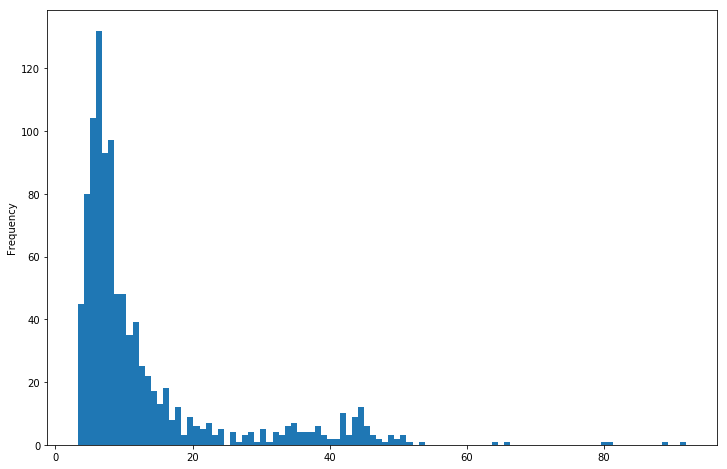

In [20]:
target.sample(1000, random_state=RANDOM_STATE).plot(kind='hist', bins=100);

C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


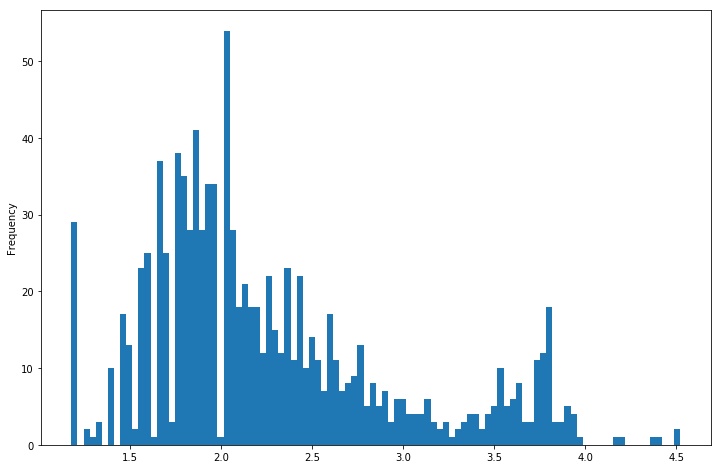

In [23]:
###target.sample(1000, random_state=RANDOM_STATE).plot(kind='hist', bins=100)
antitarget = np.log(target)
antitarget.sample(1000, random_state=RANDOM_STATE).plot(kind='hist', bins=100)

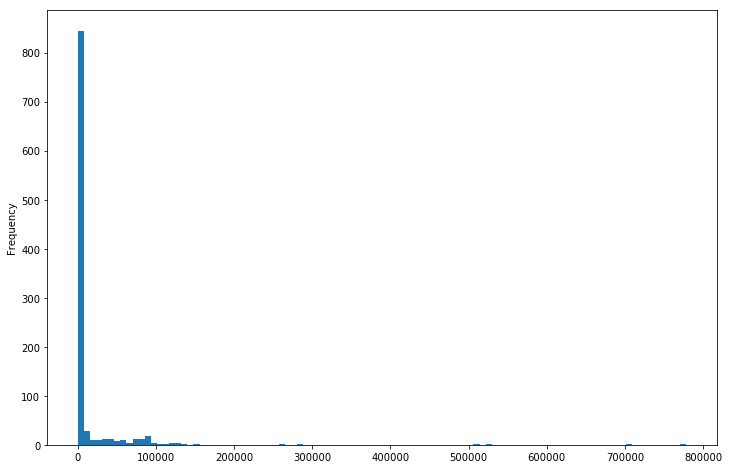

In [26]:
antitarget = (target**3)
antitarget.sample(1000, random_state=RANDOM_STATE).plot(kind='hist', bins=100)

**<font color='red'>Вопрос №3.</font> Каково максимальное расстояние (`great-circle distance` из библиотеки `geopy`, в км) между точками `pickup` и `dropoff`?** <br>(Для ускорения подсчета можно использовать `joblib`)
- 27.23
- 19.91
- 23.52
- 43.66

In [79]:
pickup_dropoff = df[['pickup_latitude', 'pickup_longitude', 
                     'dropoff_latitude', 'dropoff_longitude']].dropna()
pickup_dropoff['pickup_latitude'] = pickup_dropoff['pickup_latitude'].astype(int).astype(str)
pickup_dropoff['pickup_longitude'] = pickup_dropoff['pickup_longitude'].astype(int).astype(str)
pickup_dropoff['dropoff_latitude'] = pickup_dropoff['dropoff_latitude'].astype(int).astype(str)
pickup_dropoff['dropoff_longitude'] = pickup_dropoff['dropoff_longitude'].astype(int).astype(str)

In [80]:
pickup_dropoff['pickup_latitude'] = pickup_dropoff['pickup_latitude'].map(column_remapping['pickup_latitude'])
pickup_dropoff['pickup_longitude'] = pickup_dropoff['pickup_longitude'].map(column_remapping['pickup_longitude'])
pickup_dropoff['dropoff_latitude'] = pickup_dropoff['dropoff_latitude'].map(column_remapping['dropoff_latitude'])
pickup_dropoff['dropoff_longitude'] = pickup_dropoff['dropoff_longitude'].map(column_remapping['dropoff_longitude'])

In [81]:
pickup_dropoff.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,41.901206994,-87.676355989,41.901206994,-87.676355989
3,41.944226601,-87.655998182,41.944226601,-87.655998182
5,41.899602111,-87.633308037,41.96581197,-87.655878786
7,41.953582125,-87.72345239,41.953582125,-87.72345239
8,41.892507781,-87.626214906,41.884987192,-87.620992913


In [82]:
from geopy.distance import great_circle
dres = pickup_dropoff.apply(
    lambda x: great_circle(
        (x['pickup_latitude'], x['pickup_longitude']),
        (x['dropoff_latitude'], x['dropoff_longitude'])
    ).km,
    axis=1)

In [83]:
dres.max()

43.662892734777216

In [47]:
pickup_dropoff.describe()
pickup_dropoff.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,199.0,510.0,199.0,510.0
3,686.0,500.0,686.0,500.0
5,599.0,346.0,660.0,120.0
7,527.0,24.0,527.0,24.0
8,210.0,470.0,744.0,605.0


Давайте обучим простую модель, прежде чем пробовать добавлять признаки.

In [196]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)*10000000000000000000
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    y_data = target.fillna(0)
    
kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
# np.abs тут нужен,т.к. sklearn по ошибке возвращает отрицательную MSE
print(np.abs(cross_val_score(LinearRegression(), 
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error')\
    .mean()))

749.105255028
Wall time: 6.12 s


**<font color='red'>Вопрос №4.</font> В ячейке выше допущено несколько ошибок и неаккуратных действий.
Что из перечисленных НЕ является проблемой, влияющей на настоящее качество модели? **

- не зафиксирован random seed
- признаки разной размерности не нормированы
- взята малая подвыборка признаков
- пропуски в целевой переменной заполнены неуместным значением по умолчанию

Слегка модифицируем обработку данных.

In [85]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
np.abs(cross_val_score(pipeline,
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error') \
    .mean())

877.7118181861897

In [87]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['tolls', 'trip_seconds', 'trip_miles']]
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
np.abs(cross_val_score(pipeline,
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error') \
    .mean())

908.72283603551205

In [88]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['tips', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
np.abs(cross_val_score(pipeline,
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error') \
    .mean())

719.77390306801885

In [89]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['tips', 'tolls', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
np.abs(cross_val_score(pipeline,
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error') \
    .mean())

905.27410823311516

In [90]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['tips', 'tolls', 'trip_seconds']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
np.abs(cross_val_score(pipeline,
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error') \
    .mean())

879.31395826444952

In [91]:
df.columns

Index(['taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds',
       'trip_miles', 'pickup_census_tract', 'dropoff_census_tract',
       'pickup_community_area', 'dropoff_community_area', 'tips', 'tolls',
       'extras', 'payment_type', 'company', 'pickup_latitude',
       'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'],
      dtype='object')

**<font color='red'>Вопрос №5.</font> Какой из признаков нужно убрать, чтобы качество модели улучшилось значительнее всего?**

- tips
- tolls 
- trip_seconds
- trip_miles
- ни один из вышеперечисленных

Давайте построим модель на двух признаках (время поездки и пройденное расстояние) и попробуем добавить еще один признак, связанный с датой. 

In [179]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['trip_start_timestamp', 'trip_seconds', 'trip_miles']]
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

timestamp = pd.to_datetime(X_data.pop('trip_start_timestamp'))

t1 = timestamp.apply(lambda x: x.dayofweek)
t2 = timestamp.apply(lambda x: 1 if x.dayofweek in (5, 6) else 0)
t3 = timestamp.apply(lambda x: x.hour)
t4 = timestamp.apply(lambda x: x.dayofweek * 24 + x.hour)

Wall time: 1min 9s


In [180]:
#y_data = y_data.apply(lambda x: np.log(x+1))
print(y_data.describe())
print(len(X_data))
print(len(y_data))
for i, t in enumerate((t1, t2, t3, t4)):
#for i, t in enumerate((t1)):
    X_data_changed = X_data.copy()
    X_data_changed['time'] = t
    #print(t.describe())
#print(len(pp), len(X_data_changed), len(y_data))
#print(pp.describe())
    #X_data_changed.loc[X_data_changed.time < 7, 'time'] = 1
    #X_data_changed.loc[X_data_changed.time >= 7, 'time'] = 0
    #print(i)
    #print(t)
    print('***')
#print(X_data_changed.describe())
    pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

    kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    print(np.abs(cross_val_score(pipeline,
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error') \
    .mean()))

    pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

#print(len(X_data_changed))
#print(len(y_data))
#print(len(X_data_changed.values))

    kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    print(np.abs(cross_val_score(pipeline,
                X=X_data_changed.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error') \
    .mean()))

    #print(kfold.params)
    
    # Ваш код здесь

count    5.432048e+06
mean     1.338758e+01
std      2.821729e+01
min      0.000000e+00
25%      6.000000e+00
50%      8.250000e+00
75%      1.375000e+01
max      9.739580e+03
Name: fare, dtype: float64
5432048
5432048
***
748.904565345
748.830518281
***
748.904565345
748.894392728
***
748.904565345
748.904920723
***
748.904565345
748.829604818


In [132]:
t1.head()

0    2
1    4
2    6
3    5
4    3
Name: trip_start_timestamp, dtype: int64

** <font color='red'>Вопрос №6.</font> Какие выводы можно сделать? **

- новые признаки не улучшают модель, т.к. автор намеренно совершил техническую ошибку
- новые признаки не улучшают модель, т.к. такова природа данных
- новые признаки улучшают модель всего на 3%
- новые признаки улучшают модель всего на 7%

** <font color='red'>Вопрос №7</font>. Отвлечемся и пофантазируем. Представим, что ввели закон, обязывающий пассажиров такси фотографировать своего водителя перед каждой поездкой и после каждой поездки; к нам, в дополнение к текущему датасету, попали эти фотографии. Как _нельзя_ было бы использовать их в предсказании цены поездки? **

- извлечь признаки водителя при помощи предобученной нейронной сети, получив значения на одном из последних полносвязных слоев
- использовать метаданные о модели телефона пассажира
- использовать геотег с обеих фотографий
- использовать время съемки

Давайте попробуем преобразовать один из признаков, чтобы избавиться от "длинного хвоста" справа.

60.0


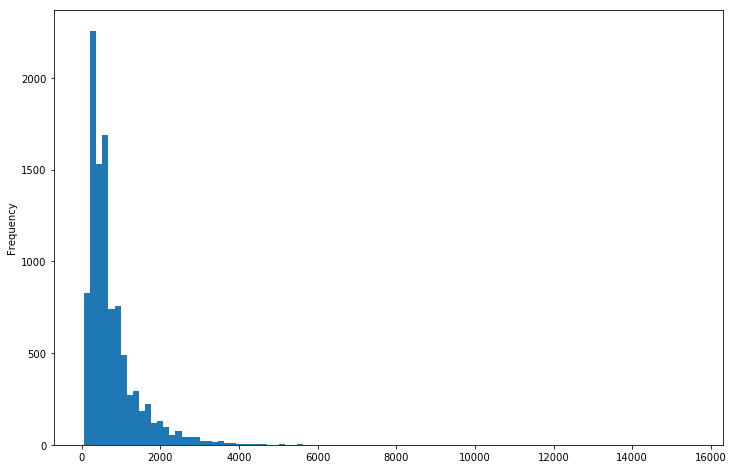

In [112]:
df_tmp = df.copy()
df_tmp = df_tmp[df_tmp.trip_seconds > 0]
print(df_tmp.trip_seconds.min())
seconds = df_tmp.trip_seconds

seconds.sample(10000).plot(kind='hist', bins=100);

32.75941753387451


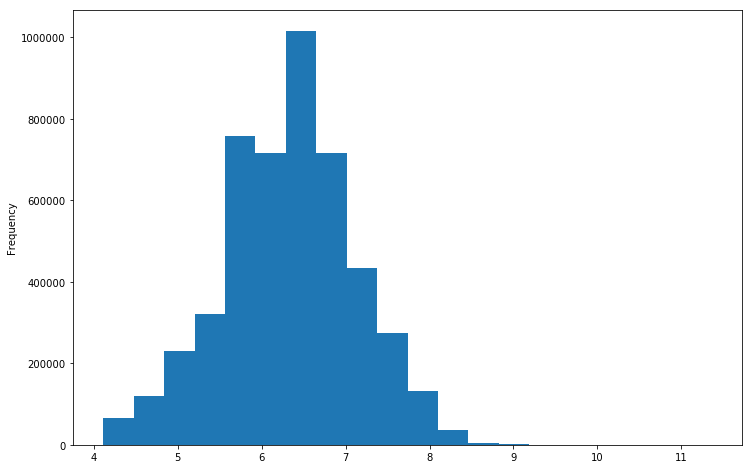

In [168]:
#import random
#%%time
#import time
#random.seed(42)
start = time.time()
#www = seconds.sample(10000,  random_state=RANDOM_STATE) 
seconds.apply(lambda x: np.log(x + 1)).plot(kind='hist', bins=20)
end = time.time()
print(end-start)

30.72710371017456


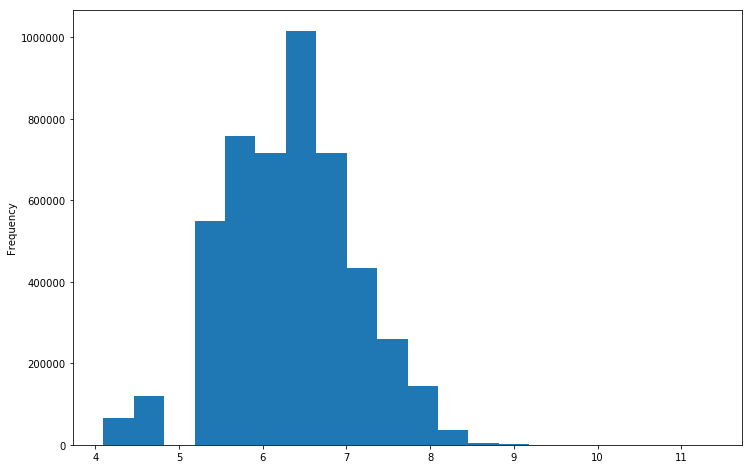

In [169]:
start = time.time()
seconds.apply(lambda x: np.log(x)).plot(kind='hist', bins=20)
end = time.time()
print(end-start)

**<font color='red'>Вопрос №8.</font> Зачем в предыдущей ячейке используется `np.log(x + 1)`, а не просто `np.log`?**

- чтобы запутать читателей
- чтобы получить бимодальное распределение
- для скорости вычисления
- во избежание `ValueError`